In [1]:
from pyspark.sql import SparkSession

# Định nghĩa constants
HDFS_HOST = "hdfs://localhost:9000"  
HDFS_PATH = f"{HDFS_HOST}/hadoop/data/parquet/"

def create_spark_session(app_name="IMDb Analytics"):
    """
    Tạo và cấu hình SparkSession với các thiết lập phù hợp.
    
    Parameters:
        app_name (str): Tên của ứng dụng Spark
        
    Returns:
        SparkSession: SparkSession đã được cấu hình
    """
    return SparkSession.builder \
        .appName(app_name) \
        .master("spark://localhost:7077") \
        .config("spark.executor.memory", "1g") \
        .config("spark.driver.memory", "1g") \
        .config("spark.hadoop.fs.defaultFS", HDFS_HOST) \
        .config("spark.sql.warehouse.dir", f"{HDFS_HOST}/user/hive/warehouse") \
        .config("spark.executor.cores", "1") \
        .config("spark.driver.cores", "1") \
        .config("spark.sql.files.maxPartitionBytes", "128MB") \
        .config("spark.sql.shuffle.partitions", "4") \
        .config("spark.executor.instances", "2")   \
        .getOrCreate()
        # .config("spark.dynamicAllocation.minExecutors", "2") \
        # .config("spark.dynamicAllocation.maxExecutors", "2") \
        #  .config("spark.dynamicAllocation.enabled", "true") 
       

# Hàm tiện ích để kiểm tra kết nối HDFS
def test_hdfs_connection(spark):
    """
    Kiểm tra kết nối tới HDFS bằng cách đọc thử một file parquet
    
    Parameters:
        spark (SparkSession): SparkSession đã được khởi tạo
        
    Returns:
        bool: True nếu kết nối thành công, False nếu thất bại
    """
    try:
        # Thử đọc một file parquet bất kỳ
        test_df = spark.read.parquet(f"{HDFS_PATH}/title_basics_parquet")
        test_df.printSchema()
        return True
    except Exception as e:
        print(f"Lỗi kết nối HDFS: {str(e)}")
        return False

In [ ]:
from pyspark.sql import SparkSession
import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.utils import AnalysisException
import subprocess

def get_file_size(hdfs_path):
    """Lấy kích thước file/thư mục từ HDFS"""
    try:
        # Với file TSV.GZ
        if hdfs_path.endswith('.tsv.gz'):
            cmd = f"hdfs dfs -ls {hdfs_path} | awk '{{print $5}}'"
            size = int(subprocess.check_output(cmd, shell=True).decode().strip())
            return size
        # Với thư mục Parquet
        else:
            cmd = f"hdfs dfs -du -s {hdfs_path} | awk '{{print $1}}'"
            size = int(subprocess.check_output(cmd, shell=True).decode().strip())
            return size
    except subprocess.CalledProcessError:
        print(f"Không thể lấy kích thước của {hdfs_path}")
        return None

def format_size(size_in_bytes):
    """Chuyển đổi kích thước từ bytes sang MB/GB"""
    if size_in_bytes is None:
        return "N/A"
    mb = size_in_bytes / (1024 * 1024)
    if mb > 1024:
        return f"{mb/1024:.2f} GB"
    return f"{mb:.2f} MB"

def measure_reading_time(spark, file_path, format_type):
    try:
        print(f"Đang thử đọc file: {file_path}")
        start_time = time.time()
        
        if format_type == 'tsv':
            df = spark.read.csv(file_path, sep='\t', header=True)
        else:
            df = spark.read.parquet(file_path)
            
        # Force computation through count action
        count = df.count()
        end_time = time.time()
        print(f"Đọc thành công: {count} dòng")
        return end_time - start_time, count
    except Exception as e:
        print(f"Lỗi khi đọc file: {str(e)}")
        return None, None

# Danh sách các file cần test
files = [
    # 'name.basics',
    # 'title.akas',
    'title.basics',
    # 'title.crew',
    # 'title.episode',
    # 'title.principals',
    # 'title.ratings'
]

results = []
for file_name in files:
    tsv_path = f'/hadoop/data/{file_name}.tsv.gz'
    # Sửa lại tên thư mục Parquet để khớp với cấu trúc thực tế
    parquet_path = f'/hadoop/data/parquet/{file_name.replace(".", "_")}_parquet'
    
    print(f"\nĐang xử lý: {file_name}")
    
    # Lấy kích thước file
    tsv_size = get_file_size(tsv_path)
    parquet_size = get_file_size(parquet_path)
    
    print(f"Kích thước TSV.GZ: {format_size(tsv_size)}")
    print(f"Kích thước Parquet: {format_size(parquet_size)}")
    
    # Chỉ thêm vào results nếu cả hai định dạng đều tồn tại
    if tsv_size is not None and parquet_size is not None:
        # Đo thời gian đọc TSV
        tsv_time, tsv_count = measure_reading_time(spark, tsv_path, 'tsv')
        
        # Đo thời gian đọc Parquet
        parquet_time, parquet_count = measure_reading_time(spark, parquet_path, 'parquet')
        
        if tsv_time and parquet_time:
            results.append({
                'file': file_name,
                'tsv_time': tsv_time,
                'parquet_time': parquet_time,
                'tsv_size': tsv_size,
                'parquet_size': parquet_size,
                'compression_ratio': (tsv_size - parquet_size) / tsv_size * 100,
                'speedup': (tsv_time - parquet_time) / tsv_time * 100,
                'tsv_count': tsv_count,
                'parquet_count': parquet_count
            })

if results:
    df_results = pd.DataFrame(results)
    
    # Tạo biểu đồ so sánh
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Biểu đồ thời gian đọc
    x = range(len(df_results))
    width = 0.35
    ax1.bar([i - width/2 for i in x], df_results['tsv_time'], width, label='TSV.GZ', color='skyblue')
    ax1.bar([i + width/2 for i in x], df_results['parquet_time'], width, label='Parquet', color='lightgreen')
    ax1.set_xlabel('Files')
    ax1.set_ylabel('Thời gian đọc (giây)')
    ax1.set_title('So sánh thời gian đọc')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_results['file'], rotation=45)
    ax1.legend()
    
    # 2. Biểu đồ kích thước file
    ax2.bar([i - width/2 for i in x], df_results['tsv_size']/(1024*1024), width, label='TSV.GZ', color='skyblue')
    ax2.bar([i + width/2 for i in x], df_results['parquet_size']/(1024*1024), width, label='Parquet', color='lightgreen')
    ax2.set_xlabel('Files')
    ax2.set_ylabel('Kích thước (MB)')
    ax2.set_title('So sánh kích thước')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_results['file'], rotation=45)
    ax2.legend()
    
    # 3. Biểu đồ tỷ lệ nén
    ax3.bar(df_results['file'], df_results['compression_ratio'], color='lightcoral')
    ax3.set_xlabel('Files')
    ax3.set_ylabel('Tỷ lệ nén (%)')
    ax3.set_title('Tỷ lệ nén của Parquet so với TSV.GZ')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # 4. Biểu đồ cải thiện tốc độ
    ax4.bar(df_results['file'], df_results['speedup'], color='lightgreen')
    ax4.set_xlabel('Files')
    ax4.set_ylabel('Cải thiện tốc độ (%)')
    ax4.set_title('Tỷ lệ cải thiện tốc độ đọc')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('format_comparison.png', dpi=300, bbox_inches='tight')
    
    # In kết quả chi tiết
    print("\nKết quả chi tiết:")
    print(df_results[['file', 'tsv_time', 'parquet_time', 'speedup']].to_string(index=False))
    
    # Tính toán và in thống kê tổng hợp
    print("\nThống kê tổng hợp:")
    print(f"Thời gian trung bình đọc TSV.GZ: {df_results['tsv_time'].mean():.2f}s")
    print(f"Thời gian trung bình đọc Parquet: {df_results['parquet_time'].mean():.2f}s")
    print(f"Tỷ lệ cải thiện tốc độ trung bình: {df_results['speedup'].mean():.2f}%")
    print(f"Tỷ lệ nén trung bình: {df_results['compression_ratio'].mean():.2f}%")
    print(f"\nFile có cải thiện tốc độ nhiều nhất: {df_results.loc[df_results['speedup'].idxmax(), 'file']} ({df_results['speedup'].max():.2f}%)")
    print(f"File có tỷ lệ nén tốt nhất: {df_results.loc[df_results['compression_ratio'].idxmax(), 'file']} ({df_results['compression_ratio'].max():.2f}%)")

spark.stop()

In [2]:
class IMDbDataLoader:
    def __init__(self, spark, base_path):
        self.spark = spark
        self.base_path = base_path
    
    def load_titles(self):
        return self.spark.read.parquet(f"{self.base_path}/title_basics_parquet") # basic in4 about titles
    
    def load_ratings(self):
        return self.spark.read.parquet(f"{self.base_path}/title_ratings_parquet") # in4 about ratings and vote counts for titles
    
    def load_names(self):
        return self.spark.read.parquet(f"{self.base_path}/name_basics_parquet") # Basic in4 about individuals

    def load_akas(self):
        return self.spark.read.parquet(f"{self.base_path}/title_akas_parquet") # In4 about alternative titles of movies or shows
        
    def load_episodes(self):
        return self.spark.read.parquet(f"{self.base_path}/title_episode_parquet") # About episodoes in a series

    def load_principals(self):
        return self.spark.read.parquet(f"{self.base_path}/title_principals_parquet") # In4 about key indivisuals related to a title
    
    def load_crews(self):
        return self.spark.read.parquet(f"{self.base_path}/title_crew_parquet") # In4 about the creative team behind the film



In [5]:
# When have 2 workers
spark = create_spark_session()

loader = IMDbDataLoader(spark, "hdfs:///hadoop/data/parquet/")

# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")


Số lượng workers đang hoạt động: 2
Executor Info: org.apache.spark.SparkExecutorInfoImpl@5125eded
Executor Info: org.apache.spark.SparkExecutorInfoImpl@4f4e81ab
Executor Info: org.apache.spark.SparkExecutorInfoImpl@760e116


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

class MovieVisualizer:
    @staticmethod
    def plot_genre_distribution(genre_df):
        """Plot genre distribution"""
        plt.figure(figsize=(12, 6))
        data = genre_df.toPandas()
        sns.barplot(data=data, x='genre', y='count')
        plt.title("Movie Genre Distribution")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Genre")
        plt.ylabel("Count")
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_job_distribution(job_df):
        """Plot job distribution in film crew"""
        plt.figure(figsize=(15, 8))
        data = job_df.toPandas()
        ax = sns.barplot(data=data, x='category', y='count', hue='job')
        plt.title("Job Distribution in Film Crew")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt.gcf()
    
    @staticmethod
    def plot_director_productivity(director_df):
        """Plot top directors"""
        plt.figure(figsize=(12, 6))
        data = director_df.toPandas()
        sns.barplot(data=data, x='director_id', y='count')
        plt.title("Top Directors by Number of Films")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Director ID")
        plt.ylabel("Number of Films")
        plt.tight_layout()
        return plt.gcf()

    @staticmethod
    def plot_top_rated_movies(movie_df):
        """Plot top-rated movies"""
        plt.figure(figsize=(12, 6))
        data = movie_df.toPandas()
        sns.barplot(data=data, x='primaryTitle', y='averageRating')
        plt.title("Top Rated Movies")
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Movie Title")
        plt.ylabel("Average Rating")
        plt.tight_layout()
        return plt.gcf()


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

def visualize_rating_variance(rating_variance_df):
    """
    Visualize rating variance and average ratings across title types.
    :param rating_variance_df: PySpark DataFrame with rating variance data
    """
    rating_variance_pd = rating_variance_df.toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.bar(rating_variance_pd['titleType'], rating_variance_pd['rating_variance'], alpha=0.7, label='Rating Variance')
    plt.plot(rating_variance_pd['titleType'], rating_variance_pd['avg_rating'], color='r', marker='o', label='Average Rating')
    plt.xlabel('Title Type')
    plt.ylabel('Metrics')
    plt.title('Rating Variance and Average Ratings by Title Type')
    plt.legend()
    plt.show()


def visualize_top_performers(high_performers_df):
    """
    Visualize the top consistently high-performing directors and writers.
    :param high_performers_df: PySpark DataFrame with high-performing crew members data
    """
    high_performers_pd = high_performers_df.limit(10).toPandas()  # Limit to top 10 for clarity
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=high_performers_pd, x='avg_rating', y='nconst', orient='h', palette='coolwarm')
    plt.xlabel('Average Rating')
    plt.ylabel('Director/Writer (nconst)')
    plt.title('Top Consistently High-Performing Directors/Writers')
    plt.show()


def visualize_crew_correlation(crew_performance_df):
    """
    Visualize correlation between crew members (directors/writers) and title ratings.
    :param crew_performance_df: PySpark DataFrame with crew performance data
    """
    crew_performance_pd = crew_performance_df.limit(20).toPandas()  # Limit to top 20 for visualization
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=crew_performance_pd, x='weighted_popularity', y='avg_rating', hue='num_titles', size='total_votes', palette='viridis')
    plt.xlabel('Weighted Popularity')
    plt.ylabel('Average Rating')
    plt.title('Correlation Between Crew Members and Title Ratings')
    plt.legend(title='Number of Titles')
    plt.show()


def visualize_rating_distribution(rating_distribution_df):
    """
    Visualize the distribution of ratings.
    :param rating_distribution_df: PySpark DataFrame with rating distribution data
    """
    rating_distribution_pd = rating_distribution_df.toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=rating_distribution_pd, x='averageRating', bins=20, kde=True, color='skyblue')
    plt.xlabel('Rating')
    plt.ylabel('Number of Titles')
    plt.title('Distribution of IMDb Ratings')
    plt.grid(True)
    plt.show()


def visualize_rating_by_title_type(avg_rating_by_title_type_df):
    """
    Visualize the average ratings by title type (movie, tvseries, etc.).
    :param avg_rating_by_title_type_df: PySpark DataFrame with average ratings by title type
    """
    avg_rating_by_title_type_pd = avg_rating_by_title_type_df.toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_rating_by_title_type_pd, x='titleType', y='avg_rating', palette='pastel')
    plt.xlabel('Title Type')
    plt.ylabel('Average Rating')
    plt.title('Average Ratings by Title Type')
    plt.show()


In [9]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    explode, col, count, desc, avg, 
    sum , when, concat_ws, asc,
    split, year, struct, dense_rank,
    var_pop,  stddev
)
from pyspark.sql.types import DoubleType 
import matplotlib.pyplot as plt
import seaborn as sns
import time


class AdvancedAnalysis:
    def __init__(self, spark_session):
        """
        Initialize AdvancedAnalysis with a SparkSession
        
        :param spark_session: Active Spark session
        """
        self.spark = spark_session
    
    def compute_genre_rating_correlation(self, title_basics_df, title_rating_df):
        """
        Compute correlation between genre and average rating
        
        :param title_basics_df: DataFrame with title basics
        :param title_rating_df: DataFrame with title ratings
        :return: Correlation matrix of genres with ratings
        """
        # One-hot encode genres
        genre_encoded_df = (
            title_basics_df
            .join(title_rating_df, 'tconst')
            .select(
                F.explode(F.split('genres', ',')).alias('genre'), 
                'averageRating'
            )
            .groupBy('genre')
            .agg(
                F.avg('averageRating').alias('avg_rating'),
                F.count('*').alias('genre_count')
            )
            .filter(F.col('genre') != '\\N')
        )
        
        # Prepare data for correlation
        assembler = VectorAssembler(
            inputCols=['avg_rating', 'genre_count'], 
            outputCol='features'
        )
        features_df = assembler.transform(genre_encoded_df)
        
        # Compute correlation matrix
        correlation_matrix = Correlation.corr(features_df, 'features')
        return correlation_matrix
    
    def analyze_crew_contribution(self, title_basics_df, title_crew_df, title_rating_df, top_n=10):
        """
        Analyze top directors and writers based on their titles' ratings
        
        :param title_basics_df: DataFrame with title basics
        :param title_crew_df: DataFrame with crew information
        :param title_rating_df: DataFrame with title ratings
        :param top_n: Number of top crew members to return
        :return: DataFrame of top crew members by average title rating
        """
        # Explode directors and join with basics and ratings
        directors_performance = (
            title_crew_df
            .select(F.explode(F.split('directors', ',')).alias('nconst'), 'tconst')
            .join(title_basics_df, 'tconst')
            .join(title_rating_df, 'tconst')
            .groupBy('nconst')
            .agg(
                F.avg('averageRating').alias('avg_title_rating'),
                F.count('*').alias('total_titles'),
                F.collect_list('primaryTitle').alias('titles')
            )
            .filter(F.col('total_titles') > 3)  # Minimum 3 titles to be considered
            .orderBy(F.desc('avg_title_rating'))
            .limit(top_n)
        )
        return directors_performance
    
    def analyze_runtime_rating_relationship(self, title_basics_df, title_rating_df):
        """
        Explore relationship between runtime and ratings
        
        :param title_basics_df: DataFrame with title basics
        :param title_rating_df: DataFrame with title ratings
        :return: DataFrame showing runtime-rating correlation
        """
        runtime_rating_analysis = (
            title_basics_df
            .join(title_rating_df, 'tconst')
            .filter(
                (F.col('runtimeMinutes') != '\\N') & 
                (F.col('runtimeMinutes').cast('int').isNotNull())
            )
            .select(
                'runtimeMinutes', 
                'averageRating', 
                'titleType'
            )
        )
        
        # Compute correlation
        assembler = VectorAssembler(
            inputCols=['runtimeMinutes', 'averageRating'], 
            outputCol='features'
        )
        features_df = assembler.transform(runtime_rating_analysis)
        correlation_matrix = Correlation.corr(features_df, 'features')
        
        return {
            'runtime_rating_df': runtime_rating_analysis,
            'correlation_matrix': correlation_matrix
        }
#bắt đầu ở đây
    def analyze_comprehensive_genre_popularity(
        titles_df, 
        rating_df, 
        crew_path=None, 
        principals_path=None
    ):
        """
        Comprehensive genre popularity analysis using multiple IMDb datasets
    
        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Optional path to title.crew.tsv.gz
        :param principals_path: Optional path to title.principals.tsv.gz
        :return: DataFrame with comprehensive genre popularity metrics
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Comprehensive Genre Popularity Analysis") \
            .getOrCreate()
    
        # Read input files
    
        # Filter out adult and low-relevance titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') &
            (col('titleType').isin(['movie', 'tvseries']))
        )
    
    # Convert ratings to numeric, handling potential null values
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )
    
    # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )
    
    # Optional: Join with crew data for additional insights
        if crew_path:
            crew_df = spark.read.csv(
                crew_path, 
                sep='\t', 
                header=True, 
                nullValue='\\N'
            )
            titles_with_ratings = titles_with_ratings.join(
                crew_df, 
                titles_with_ratings['tconst'] == crew_df['tconst'], 
            'left'
            )
    
    # Explode genres and aggregate
        genre_popularity = titles_with_ratings \
            .select(
                explode(col('genres').split(',')).alias('genre'),
                col('averageRating').alias('rating'),
                col('numVotes').alias('votes'),
                col('titleType')
            ) \
            .groupBy('genre') \
            .agg(
            # Basic metrics
                count('*').alias('total_titles'),
                avg('rating').alias('avg_rating'),
                sum('votes').alias('total_votes'),
            
            # Weighted popularity score
            # Combine rating and vote count for a comprehensive metric
                (avg('rating') * sum('votes')).alias('weighted_popularity'),
            
            # Breakdown by title type
                count(when(col('titleType') == 'movie', 1)).alias('movie_count'),
                count(when(col('titleType') == 'tvseries', 1)).alias('tvseries_count')
            )
    
    # Calculate percentages and final popularity score
        total_titles = filtered_titles.count()
    
        final_genre_popularity = genre_popularity \
            .withColumn('title_percentage', 
                    col('total_titles') / total_titles * 100) \
            .withColumn('popularity_score', 
                    col('weighted_popularity') / sum('weighted_popularity').over()) \
            .orderBy(desc('popularity_score'))
    
        return final_genre_popularity

    def analyze_genre_trends(basics_path, ratings_path):
        spark = SparkSession.builder \
        .appName("GenreTrendsAnalysis") \
        .getOrCreate()
    
    # Read title basics and ratings data
        title_basics = spark.read.csv(basics_path, sep='\t', header=True, nullValue='\\N')
        title_ratings = spark.read.csv(ratings_path, sep='\t', header=True, nullValue='\\N')
    
    # Prepare the basics dataframe
        basics_prepared = title_basics.select(
            col("tconst"),
            col("startYear"),
            explode(split(col("genres"), ",")).alias("genre")
        ).filter(col("startYear") != "\\N")  # Remove entries without a year
    
    # Cast startYear to integer
        basics_prepared = basics_prepared.withColumn(
            "startYear", 
            col("startYear").cast("integer")
        )
    
    # Join with ratings to get rating information
        genre_trends = basics_prepared.join(
            title_ratings, 
            "tconst"
        ).select(
            "startYear",
            "genre",
            "averageRating",
            "numVotes"
        )
    
        # Compute genre trends per year
        genre_year_stats = genre_trends.groupBy(
            "startYear", 
            "genre"
        ).agg(
            avg("averageRating").alias("avg_rating"),
            count("*").alias("title_count"),
            sum("numVotes").alias("total_votes")
        )
        
        # Filter out very sparse genres (optional)
        genre_popularity = genre_year_stats.filter(col("title_count") > 10)
        
        # Find top genres by total votes for each year
        window_spec = Window.partitionBy("startYear").orderBy(desc("total_votes"))
        top_genres_by_year = genre_popularity.withColumn(
            "genre_rank", 
            dense_rank().over(window_spec)
        ).filter(col("genre_rank") <= 5)
        
        # Action: Show top genres trend
        top_genres_by_year.orderBy("startYear", "genre_rank").show(100, truncate=False)
        
        # Optional: Save results to a CSV
        top_genres_by_year.write.mode("overwrite").csv(
            "genre_trends_analysis", 
            header=True
        )
        
        return top_genres_by_year
    def analyze_genre_popularity(spark, titles_path, akas_path, ratings_path):
        """
        Analyze genre popularity by region and language
        
        :param spark: SparkSession
        :param titles_path: Path to title.basics.tsv.gz
        :param akas_path: Path to title.akas.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrame with genre popularity metrics
        """
        # Load datasets
        titles_df = spark.read.option("sep", "\t").option("header", "true").option("nullValue", "\\N").csv(titles_path)
        akas_df = spark.read.option("sep", "\t").option("header", "true").option("nullValue", "\\N").csv(akas_path)
        rating_df = spark.read.option("sep", "\t").option("header", "true").option("nullValue", "\\N").csv(ratings_path)
        
        # Prepare and join data
        genre_analysis = (titles_df
            .filter((col("titleType").isin(["movie", "tvSeries"])) & (col("isAdult") == 0))
            .select("tconst", explode(split(col("genres"), ",")).alias("genre"))
            .join(rating_df, "tconst")
            .join(akas_df, "tconst")
            .select("tconst", "genre", "averageRating", "numVotes", "region", "language")
        )
        
        # Analyze genre popularity by region
        genre_popularity_by_region = (genre_analysis
            .groupBy("region", "genre")
            .agg(
                count("tconst").alias("total_titles"),
                avg("averageRating").alias("avg_rating"),
                avg("numVotes").alias("avg_votes")
            )
            .orderBy(desc("total_titles"))
        )
        
        # Analyze genre popularity by language
        genre_popularity_by_language = (genre_analysis
            .groupBy("language", "genre")
            .agg(
                count("tconst").alias("total_titles"),
                avg("averageRating").alias("avg_rating"),
                avg("numVotes").alias("avg_votes")
            )
            .orderBy(desc("total_titles"))
        )
        
        return {
            "by_region": genre_popularity_by_region,
            "by_language": genre_popularity_by_language
        }
    def analyze_emerging_declining_genres(
        titles_df, 
       rating_df, 
        crew_path=None, 
    ):
        """
        Analyze emerging or declining genres based on popularity trends over time using IMDb datasets.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Optional path to title.crew.tsv.gz
        :param principals_path: Optional path to title.principals.tsv.gz
        :return: DataFrame with genre popularity trends over time
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Emerging or Declining Genres Analysis") \
            .getOrCreate()

        # Filter out adult and low-relevance titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric, handling potential null values
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # Optional: Join with crew data for additional insights
        if crew_path:
            crew_df = spark.read.csv(
                crew_path, 
                sep='\t', 
                header=True, 
                nullValue='\\N'
            )
            titles_with_ratings = titles_with_ratings.join(
                crew_df, 
                titles_with_ratings['tconst'] == crew_df['tconst'], 
                'left'
            )

        # Explode genres and aggregate to get genre-wise popularity metrics
        genre_popularity = titles_with_ratings \
            .select(
                explode(split(col('genres'), ',')).alias('genre'),
                col('averageRating').alias('rating'),
                col('numVotes').alias('votes'),
                col('titleType'),
                col('startYear')  # Adding startYear for time-based analysis
            ) \
            .filter(col('startYear').isNotNull())  # Remove entries without a start year

        # Group by genre and startYear to track trends over time
        genre_trends = genre_popularity \
            .groupBy('genre', 'startYear') \
            .agg(
                count('*').alias('total_titles'),
                avg('rating').alias('avg_rating'),
                avg('votes').alias('avg_votes'),
                sum('votes').alias('total_votes')
            )

        # Calculate weighted popularity score
        genre_trends = genre_trends.withColumn(
            'weighted_popularity',
            col('avg_rating') * col('total_votes')
        )

        # Calculate percentage of total titles per year
        total_titles_per_year = genre_trends.groupBy('startYear').agg(
            sum('total_titles').alias('total_titles_year')
        )

        genre_trends = genre_trends.join(
            total_titles_per_year,
            genre_trends['startYear'] == total_titles_per_year['startYear'],
            'left'
        ).withColumn(
            'title_percentage',
            col('total_titles') / col('total_titles_year') * 100
        )

        # Calculate trends: change in genre popularity over time
        window_spec = Window.partitionBy('genre').orderBy('startYear')

        genre_trends = genre_trends.withColumn(
            'popularity_change',
            col('weighted_popularity') - lag('weighted_popularity', 1).over(window_spec)
        )

        # Identify emerging genres (positive trend) and declining genres (negative trend)
        emerging_genres = genre_trends.filter(col('popularity_change') > 0)
        declining_genres = genre_trends.filter(col('popularity_change') < 0)

        # Combine the results into one DataFrame for better insights
        emerging_declining_genres = emerging_genres.unionByName(declining_genres)

        # Order by popularity change (ascending for declining, descending for emerging)
        final_result = emerging_declining_genres \
            .orderBy(
                col('popularity_change').desc(),  # Top emerging genres first
                col('popularity_change').asc()   # Declining genres after
            )

        return final_result
    def analyze_top_rated_titles(
        titles_df, 
        rating_df, 
        crew_path=None, 
        principals_path=None
    ):
        """
        Analyze top-rated titles across different categories (genres, title types) using IMDb datasets.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Optional path to title.crew.tsv.gz
        :param principals_path: Optional path to title.principals.tsv.gz
        :return: DataFrame with top-rated titles by genre and title type
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Top-Rated Titles Analysis") \
            .getOrCreate()


        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # Optional: Join with crew data for additional insights
        if crew_path:
            crew_df = spark.read.csv(
                crew_path, 
                sep='\t', 
                header=True, 
                nullValue='\\N'
            )
            titles_with_ratings = titles_with_ratings.join(
                crew_df, 
                titles_with_ratings['tconst'] == crew_df['tconst'], 
                'left'
            )

        # Explode genres and aggregate to get genre-wise popularity metrics
        genre_ratings = titles_with_ratings \
            .select(
                explode(split(col('genres'), ',')).alias('genre'),
                col('averageRating').alias('rating'),
                col('titleType')
            )

        # Get top-rated titles per genre
        top_rated_genre = genre_ratings \
            .groupBy('genre') \
            .agg(
                avg('rating').alias('avg_rating'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))  # Top-rated genre first

        # Get top-rated titles by title type (e.g., movies vs tvseries)
        top_rated_title_type = titles_with_ratings \
            .groupBy('titleType') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))  # Top-rated title type first

        # Get top-rated titles overall
        top_rated_overall = titles_with_ratings \
            .select('tconst', 'primaryTitle', 'averageRating', 'titleType') \
            .orderBy(desc('averageRating')) \
            .limit(10)  # You can adjust the number of top titles

        # Combine all results into one DataFrame for a comprehensive overview
        top_rated = {
            "top_rated_genre": top_rated_genre,
            "top_rated_title_type": top_rated_title_type,
            "top_rated_overall": top_rated_overall
        }

        return top_rated
    def analyze_rating_distribution(
        titles_path, 
        ratings_path, 
        crew_path=None, 
        principals_path=None
    ):
        """
        Analyze the distribution of ratings across IMDb titles.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Optional path to title.crew.tsv.gz
        :param principals_path: Optional path to title.principals.tsv.gz
        :return: DataFrame with rating distribution metrics
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Rating Distribution Analysis") \
            .getOrCreate()

        # Read input files
        titles_df = spark.read.csv(
            titles_path, 
            sep='\t', 
            header=True, 
            nullValue='\\N'
        )

        rating_df = spark.read.csv(
            ratings_path, 
            sep='\t', 
            header=True, 
            nullValue='\\N'
        )

        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # 1. Overall Distribution of Ratings
        rating_distribution = titles_with_ratings \
            .groupBy('averageRating') \
            .agg(
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('averageRating'))  # Sort by rating value

        # 2. Rating Ranges: Create categories like 0-2, 2-4, 4-6, etc.
        rating_ranges = titles_with_ratings \
            .withColumn('rating_range', 
                        when(col('averageRating') < 2, '0-2')
                        .when(col('averageRating') < 4, '2-4')
                        .when(col('averageRating') < 6, '4-6')
                        .when(col('averageRating') < 8, '6-8')
                        .otherwise('8-10')
            ) \
            .groupBy('rating_range') \
            .agg(
                count('*').alias('num_titles')
            ) \
            .orderBy('rating_range')

        # 3. Plotting the Distribution using a Histogram
        ratings_data = titles_with_ratings.select('averageRating').rdd.flatMap(lambda x: x).collect()
        
        # Plot the distribution
        plt.figure(figsize=(10,6))
        plt.hist(ratings_data, bins=20, edgecolor='black', color='skyblue')
        plt.title("Distribution of IMDb Ratings")
        plt.xlabel('Rating')
        plt.ylabel('Number of Titles')
        plt.grid(True)
        plt.show()

        return {
            "rating_distribution": rating_distribution,
            "rating_ranges": rating_ranges
        }
    
    def analyze_ratings_by_title_type(
        titles_df, 
        rating_df, 
        crew_path=None, 
        principals_path=None
    ):
        """
        Analyze the correlation between ratings and title type (movie, tvseries) using IMDb datasets.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Optional path to title.crew.tsv.gz
        :param principals_path: Optional path to title.principals.tsv.gz
        :return: DataFrame with average ratings per title type and visualizations
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Correlation Between Ratings and Title Type") \
            .getOrCreate()

        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # 1. Calculate the average rating by title type (movie, tvseries)
        avg_rating_by_title_type = titles_with_ratings \
            .groupBy('titleType') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))
         # 2. Visualize ratings by title type (boxplot or histogram)
        title_type_data = titles_with_ratings.select('averageRating', 'titleType').toPandas()

        # Set up the plot
        plt.figure(figsize=(10,6))
        sns.boxplot(data=title_type_data, x='titleType', y='averageRating', palette="Set2")
        plt.title('Distribution of Ratings by Title Type')
        plt.xlabel('Title Type')
        plt.ylabel('Average Rating')
        plt.show()
        # Optional: If you want to perform a t-test or further statistical analysis,
        # you could extract the ratings for each title type and compare them.

        return avg_rating_by_title_type
    def analyze_director_writer_performance(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
    ):
        """
        Analyze the performance metrics of directors and writers based on IMDb datasets.
        Metrics include average rating, total votes, number of titles, and weighted popularity.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Path to title.crew.tsv.gz
        :param principals_path: Path to title.principals.tsv.gz
        :return: DataFrame with performance metrics for directors and writers
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Director and Writer Performance Analysis") \
            .getOrCreate()


        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # Director Performance Metrics
        directors_df = crew_df.filter(col('job') == 'Director') \
            .select('tconst', 'nconst').distinct()  # Only distinct directors for each title

        # Join director data with title ratings
        directors_with_ratings = titles_with_ratings.join(
            directors_df, 
            titles_with_ratings['tconst'] == directors_df['tconst'],
            'inner'
        )

        # Aggregate metrics for directors
        director_performance = directors_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .orderBy(desc('weighted_popularity'))  # Sort by weighted popularity

        # Writer Performance Metrics
        writers_df = principals_df.filter(col('category') == 'writer') \
            .select('tconst', 'nconst').distinct()  # Only distinct writers for each title

        # Join writer data with title ratings
        writers_with_ratings = titles_with_ratings.join(
            writers_df, 
            titles_with_ratings['tconst'] == writers_df['tconst'],
            'inner'
        )

        # Aggregate metrics for writers
        writer_performance = writers_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .orderBy(desc('weighted_popularity'))  # Sort by weighted popularity

        # Combine director and writer performance data
        combined_performance = director_performance.unionByName(writer_performance)

        return combined_performance
    def analyze_crew_performance_and_ratings(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
    ):
        """
        Analyze the correlation between crew members (e.g., directors, writers) and title ratings.
        The metrics include average rating, number of titles, total votes, and weighted popularity.

        :param titles_df: Path to title.basics.tsv.gz
        :param rating_df: Path to title.ratings.tsv.gz
        :param crew_df: Path to title.crew.tsv.gz
        :param principals_df: Path to title.principals.tsv.gz
        :return: DataFrame with performance metrics for crew members (directors, writers) and their correlation with ratings
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Crew Performance and Ratings Analysis") \
            .getOrCreate()

        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # Director Performance Metrics (from crew_df)
        directors_df = crew_df.filter(col('job') == 'Director') \
            .select('tconst', 'nconst').distinct()  # Only distinct directors for each title

        # Join director data with title ratings
        directors_with_ratings = titles_with_ratings.join(
            directors_df, 
            titles_with_ratings['tconst'] == directors_df['tconst'],
            'inner'
        )

        # Aggregate metrics for directors
        director_performance = directors_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .orderBy(desc('weighted_popularity'))  # Sort by weighted popularity

        # Writer Performance Metrics (from principals_df)
        writers_df = principals_df.filter(col('category') == 'writer') \
            .select('tconst', 'nconst').distinct()  # Only distinct writers for each title

        # Join writer data with title ratings
        writers_with_ratings = titles_with_ratings.join(
            writers_df, 
            titles_with_ratings['tconst'] == writers_df['tconst'],
            'inner'
        )

        # Aggregate metrics for writers
        writer_performance = writers_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .orderBy(desc('weighted_popularity'))  # Sort by weighted popularity

        # Combine director and writer performance data
        combined_performance = director_performance.unionByName(writer_performance)

        # Optionally: Analyze correlation or perform statistical tests here if needed
        # This could include looking at correlations between weighted popularity and ratings, etc.

        return combined_performance
    def identify_consistently_high_performing_crew(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df,
        avg_rating_threshold=8.0,  # Threshold for "high-performing" average rating
        min_titles_threshold=5     # Minimum number of titles to consider consistency
    ):
        """
        Identify consistently high-performing directors and writers based on IMDb ratings and votes.
        
        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Path to title.crew.tsv.gz
        :param principals_path: Path to title.principals.tsv.gz
        :param avg_rating_threshold: The threshold for high-performing average ratings (default is 8.0)
        :param min_titles_threshold: Minimum number of titles to be considered as consistently high-performing (default is 5)
        :return: DataFrame with consistently high-performing directors and writers
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Consistently High-Performing Crew Analysis") \
            .getOrCreate()


        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('genres') != '\\N') & 
            (col('titleType').isin(['movie', 'tvseries']))
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'left'
        )

        # Director Performance Metrics (from crew_df)
        directors_df = crew_df.filter(col('job') == 'Director') \
            .select('tconst', 'nconst').distinct()  # Only distinct directors for each title

        # Join director data with title ratings
        directors_with_ratings = titles_with_ratings.join(
            directors_df, 
            titles_with_ratings['tconst'] == directors_df['tconst'],
            'inner'
        )

        # Aggregate metrics for directors
        director_performance = directors_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .filter(
                (col('avg_rating') >= avg_rating_threshold) &  # Apply average rating threshold
                (col('num_titles') >= min_titles_threshold)   # Apply minimum number of titles threshold
            ) \
            .orderBy(desc('avg_rating'))  # Sort by avg rating

        # Writer Performance Metrics (from principals_df)
        writers_df = principals_df.filter(col('category') == 'writer') \
            .select('tconst', 'nconst').distinct()  # Only distinct writers for each title

        # Join writer data with title ratings
        writers_with_ratings = titles_with_ratings.join(
            writers_df, 
            titles_with_ratings['tconst'] == writers_df['tconst'],
            'inner'
        )

        # Aggregate metrics for writers
        writer_performance = writers_with_ratings \
            .groupBy('nconst') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles'),
                sum('numVotes').alias('total_votes'),
                (avg('averageRating') * sum('numVotes')).alias('weighted_popularity')
            ) \
            .filter(
                (col('avg_rating') >= avg_rating_threshold) &  # Apply average rating threshold
                (col('num_titles') >= min_titles_threshold)   # Apply minimum number of titles threshold
            ) \
            .orderBy(desc('avg_rating'))  # Sort by avg rating

        # Combine director and writer performance data
        combined_performance = director_performance.unionByName(writer_performance)

        return combined_performance
    def analyze_rating_variance_by_title_type(
        titles_df, 
        rating_df
    ):
        """
        Analyze the variance in ratings across different title types using IMDb datasets.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrame with rating variance, average rating, and title count by title type
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Rating Variance by Title Type") \
            .getOrCreate()

        # Filter out adult content and invalid titles
        filtered_titles = titles_df.filter(
            (col('isAdult') == '0') & 
            (col('titleType').isNotNull())
        )

        # Convert ratings to numeric types
        rating_df = rating_df.withColumn(
            'averageRating', 
            col('averageRating').cast(DoubleType())
        ).withColumn(
            'numVotes', 
            col('numVotes').cast('integer')
        )

        # Join titles with ratings
        titles_with_ratings = filtered_titles.join(
            rating_df, 
            filtered_titles['tconst'] == rating_df['tconst'], 
            'inner'
        )

        # Calculate variance, average rating, and count by title type
        rating_variance_by_type = titles_with_ratings \
            .groupBy('titleType') \
            .agg(
                var_pop('averageRating').alias('rating_variance'),
                avg('averageRating').alias('avg_rating'),
                count('tconst').alias('num_titles')
            ) \
            .orderBy(desc('rating_variance'))  # Sort by variance descending

        return rating_variance_by_type
    def analyze_rating_consistency(
        titles_df, 
        rating_df, 
        crew_df, 
        output_crew_insights=False
    ):
        """
        Analyze rating consistency across IMDb titles.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :param crew_path: Path to title.crew.tsv.gz
        :param output_crew_insights: If True, includes crew-specific insights
        :return: Dictionary containing dataframes for rating consistency analysis
        """
       

        spark = SparkSession.builder \
            .appName("Rating Consistency Analysis") \
            .getOrCreate()

        # Filter and preprocess titles
        titles_df = titles_df.filter((col('isAdult') == '0') & (col('genres') != '\\N'))
        titles_df = titles_df.withColumn('genres', split(col('genres'), ','))  # Split genres into array
        rating_df = rating_df.withColumn('averageRating', col('averageRating').cast(DoubleType()))
        rating_df = rating_df.withColumn('numVotes', col('numVotes').cast('integer'))

        # Join datasets
        titles_with_ratings = titles_df.join(rating_df, 'tconst', 'left')
        titles_with_crew = titles_with_ratings.join(crew_df, 'tconst', 'left')

        # Explode genres for analysis
        titles_with_genres = titles_with_ratings.withColumn('genre', explode(col('genres')))

        # 1. Consistency by Genre
        genre_consistency = titles_with_genres.groupBy('genre') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                stddev('averageRating').alias('rating_stddev'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))

        # 2. Consistency by Directors and Writers
        crew_consistency = None
        if output_crew_insights:
            directors_consistency = titles_with_crew.withColumn('director', explode(split(col('directors'), ','))) \
                .groupBy('director') \
                .agg(
                    avg('averageRating').alias('avg_rating'),
                    stddev('averageRating').alias('rating_stddev'),
                    count('*').alias('num_titles')
                ) \
                .orderBy(desc('avg_rating'))

            writers_consistency = titles_with_crew.withColumn('writer', explode(split(col('writers'), ','))) \
                .groupBy('writer') \
                .agg(
                    avg('averageRating').alias('avg_rating'),
                    stddev('averageRating').alias('rating_stddev'),
                    count('*').alias('num_titles')
                ) \
                .orderBy(desc('avg_rating'))

            crew_consistency = {
                "directors": directors_consistency,
                "writers": writers_consistency
            }

        # 3. Plot rating variance by genre
        genre_stats = genre_consistency.toPandas()
        genre_stats.plot(
            kind='bar', x='genre', y='rating_stddev',
            title='Rating Variance by Genre', legend=False,
            figsize=(12, 6)
        )
        plt.xlabel("Genre")
        plt.ylabel("Rating Variance")
        plt.grid(True)
        plt.show()

  
        # Return results
        return {
            "genre_consistency": genre_consistency,
            "crew_consistency": crew_consistency
        }
    def analyze_runtime_perception(titles_df, rating_df):
        """
        Analyze the effect of runtime on audience perception.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrame with runtime analysis results
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Runtime Perception Analysis") \
            .getOrCreate()

        # Filter and preprocess titles
        titles_df = titles_df.filter((col('isAdult') == '0') & (col('runtimeMinutes') != '\\N'))
        titles_df = titles_df.withColumn('runtimeMinutes', col('runtimeMinutes').cast(IntegerType()))
        rating_df = rating_df.withColumn('averageRating', col('averageRating').cast(DoubleType()))
        rating_df = rating_df.withColumn('numVotes', col('numVotes').cast(IntegerType()))

        # Join datasets
        titles_with_ratings = titles_df.join(rating_df, 'tconst', 'left')

        # Create runtime bins
        titles_with_bins = titles_with_ratings.withColumn(
            'runtime_bin',
            when(col('runtimeMinutes') < 30, '<30 min')
            .when(col('runtimeMinutes') <= 60, '30-60 min')
            .when(col('runtimeMinutes') <= 90, '60-90 min')
            .when(col('runtimeMinutes') <= 120, '90-120 min')
            .otherwise('>120 min')
        )

        # Analyze runtime effects
        runtime_analysis = titles_with_bins.groupBy('runtime_bin') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                stddev('averageRating').alias('rating_stddev'),
                avg('numVotes').alias('avg_votes'),
                count('*').alias('num_titles')
            ) \
            .orderBy('runtime_bin')

        # Visualize runtime vs. average rating
        runtime_stats = runtime_analysis.toPandas()
        plt.figure(figsize=(10, 6))
        plt.bar(runtime_stats['runtime_bin'], runtime_stats['avg_rating'], color='skyblue', edgecolor='black')
        plt.title("Average Rating by Runtime Bin")
        plt.xlabel("Runtime Bin")
        plt.ylabel("Average Rating")
        plt.grid(axis='y')
        plt.show()

        # Visualize runtime vs. average votes
        plt.figure(figsize=(10, 6))
        plt.bar(runtime_stats['runtime_bin'], runtime_stats['avg_votes'], color='lightgreen', edgecolor='black')
        plt.title("Average Number of Votes by Runtime Bin")
        plt.xlabel("Runtime Bin")
        plt.ylabel("Average Votes")
        plt.grid(axis='y')
        plt.show()

        return runtime_analysis
    def analyze_audience_preferences_by_genre(titles_df, rating_df):
        """
        Analyze audience preferences across genres based on ratings and vote counts.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrame with genre preference metrics
        """
   

        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Audience Preferences by Genre") \
            .getOrCreate()

        # Filter and preprocess titles
        titles_df = titles_df.filter((col('isAdult') == '0') & (col('genres') != '\\N'))
        titles_df = titles_df.withColumn('genres', split(col('genres'), ','))  # Split genres into array
        rating_df = rating_df.withColumn('averageRating', col('averageRating').cast(DoubleType()))
        rating_df = rating_df.withColumn('numVotes', col('numVotes').cast('integer'))

        # Join datasets
        titles_with_ratings = titles_df.join(rating_df, 'tconst', 'left')

        # Explode genres for analysis
        titles_with_genres = titles_with_ratings.withColumn('genre', explode(col('genres')))

        # Analyze preferences by genre
        genre_preferences = titles_with_genres.groupBy('genre') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                stddev('averageRating').alias('rating_stddev'),
                avg('numVotes').alias('avg_votes'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))

        # Visualize audience preferences by genre
        genre_stats = genre_preferences.toPandas()

        # Plot average ratings by genre
        genre_stats.sort_values('avg_rating', ascending=False, inplace=True)
        genre_stats.plot(
            kind='bar', x='genre', y='avg_rating',
            title='Average Rating by Genre', legend=False,
            figsize=(12, 6)
        )
        plt.xlabel("Genre")
        plt.ylabel("Average Rating")
        plt.grid(True)
        plt.show()

        # Plot average votes by genre
        genre_stats.sort_values('avg_votes', ascending=False, inplace=True)
        genre_stats.plot(
            kind='bar', x='genre', y='avg_votes',
            title='Average Votes by Genre', legend=False,
            figsize=(12, 6)
        )
        plt.xlabel("Genre")
        plt.ylabel("Average Votes")
        plt.grid(True)
        plt.show()

        return genre_preferences
    def identify_consistent_genres(titles_df, rating_df):
        """
        Identify genres with the most consistent and inconsistent ratings.

        :param titles_path: Path to title.basics.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrames for consistent and inconsistent genres
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Consistent/Inconsistent Genre Ratings") \
            .getOrCreate()

        # Filter and preprocess titles
        titles_df = titles_df.filter((col('isAdult') == '0') & (col('genres') != '\\N'))
        titles_df = titles_df.withColumn('genres', split(col('genres'), ','))  # Split genres into array
        rating_df = rating_df.withColumn('averageRating', col('averageRating').cast(DoubleType()))
        rating_df = rating_df.withColumn('numVotes', col('numVotes').cast('integer'))

        # Join datasets
        titles_with_ratings = titles_df.join(rating_df, 'tconst', 'left')

        # Explode genres for analysis
        titles_with_genres = titles_with_ratings.withColumn('genre', explode(col('genres')))

        # Calculate consistency metrics by genre
        genre_consistency = titles_with_genres.groupBy('genre') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                stddev('averageRating').alias('rating_stddev'),
                count('*').alias('num_titles')
            ) \
            .filter(col('num_titles') > 50)  # Filter for genres with significant data
        
        # Most consistent genres (lowest standard deviation)
        most_consistent_genres = genre_consistency.orderBy(asc('rating_stddev')).limit(5)

        # Most inconsistent genres (highest standard deviation)
        most_inconsistent_genres = genre_consistency.orderBy(desc('rating_stddev')).limit(5)

        # Show bar charts for consistency
        consistent_df = most_consistent_genres.toPandas()
        inconsistent_df = most_inconsistent_genres.toPandas()

        # Plotting most consistent genres
        consistent_df.plot(
            kind='bar', x='genre', y='rating_stddev',
            title='Most Consistent Genres (Low Std Dev)', legend=False,
            figsize=(12, 6), color='skyblue', edgecolor='black'
        )
        plt.xlabel("Genre")
        plt.ylabel("Rating Standard Deviation")
        plt.grid(axis='y')
        plt.show()

        # Plotting most inconsistent genres
        inconsistent_df.plot(
            kind='bar', x='genre', y='rating_stddev',
            title='Most Inconsistent Genres (High Std Dev)', legend=False,
            figsize=(12, 6), color='orange', edgecolor='black'
        )
        plt.xlabel("Genre")
        plt.ylabel("Rating Standard Deviation")
        plt.grid(axis='y')
        plt.show()

        return {
            "most_consistent_genres": most_consistent_genres,
            "most_inconsistent_genres": most_inconsistent_genres
        }
    def compare_ratings_across_regions(akas_df, rating_df):
        """
        Compare average ratings across different regions.

        :param akas_path: Path to title.akas.tsv.gz
        :param ratings_path: Path to title.ratings.tsv.gz
        :return: DataFrame with regional rating comparison
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Regional Ratings Comparison") \
            .getOrCreate()

        # Filter relevant data
        akas_df = akas_df.filter((col('region') != '\\N') & (col('region') != 'None'))
        rating_df = rating_df.withColumn('averageRating', col('averageRating').cast('double'))
        rating_df = rating_df.withColumn('numVotes', col('numVotes').cast('integer'))

        # Join regional data with ratings
        regional_ratings = akas_df.join(rating_df, 'titleId', 'inner')

        # Aggregate average ratings and number of titles per region
        region_comparison = regional_ratings.groupBy('region') \
            .agg(
                avg('averageRating').alias('avg_rating'),
                count('*').alias('num_titles')
            ) \
            .orderBy(desc('avg_rating'))

        # Filter regions with a significant number of titles
        significant_regions = region_comparison.filter(col('analyze_rating_consistency'))
        top_regions = significant_regions.limit(10)

        # Plotting regional comparison
        top_regions_pd = top_regions.toPandas()

        # Bar chart of average ratings by region
        top_regions_pd.plot(
            kind='bar', x='region', y='avg_rating',
            title='Top Regions by Average Rating', legend=False,
            figsize=(12, 6), color='skyblue', edgecolor='black'
        )
        plt.xlabel("Region")
        plt.ylabel("Average Rating")
        plt.grid(axis='y')
        plt.show()

        return significant_regions
    def analyze_content_type_trends(titles_df):
        """
        Analyze changes in content type production over time.

        :param titles_path: Path to title.basics.tsv.gz
        :return: DataFrame with content type trends over time
        """
        # Initialize Spark Session
        spark = SparkSession.builder \
            .appName("Content Type Trends Analysis") \
            .getOrCreate()

        # Filter out invalid or incomplete data
        titles_df = titles_df.filter((col('startYear') != '\\N') & (col('titleType') != '\\N'))
        titles_df = titles_df.withColumn('startYear', col('startYear').cast('int'))

        # Group by content type and start year, counting the number of titles
        content_type_trends = titles_df.groupBy('startYear', 'titleType') \
            .agg(count('*').alias('num_titles')) \
            .orderBy('startYear', 'titleType')

        # Collect data for visualization
        trends_pd = content_type_trends.toPandas()

        # Plot trends
        plt.figure(figsize=(14, 8))
        for content_type in trends_pd['titleType'].unique():
            subset = trends_pd[trends_pd['titleType'] == content_type]
            plt.plot(subset['startYear'], subset['num_titles'], label=content_type)

        plt.title('Changes in Content Type Production Over Time')
        plt.xlabel('Year')
        plt.ylabel('Number of Titles')
        plt.legend(title="Content Type")
        plt.grid(True)
        plt.show()

        return content_type_trends

In [13]:
import setuptools.dist
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    explode, col, count, desc, avg, 
    sum , when, concat_ws,
    split, year, struct, dense_rank,
    var_pop,  
)
class AdvancedUsage:
    def top_rated_titles_usage(titles_df,rating_df,crew_df,principals_df):
        top_rated= AdvancedAnalysis.analyze_top_rated_titles(titles_df,rating_df,crew_df,principals_df)

        # Top-rated titles by genre
        top_rated_genre = top_rated["top_rated_genre"]
        top_rated_genre.show()

        # Top-rated titles by title type (movie vs tvseries)
        top_rated_title_type = top_rated["top_rated_title_type"]
        top_rated_title_type.show()

        # Top-rated titles overall
        top_rated_overall = top_rated["top_rated_overall"]
        top_rated_overall.show()
    def analyze_rating_distribution_usage(titles_df,rating_df,crew_df,principals_df):
        rating_distribution = AdvancedAnalysis.analyze_rating_distribution(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
        )
        rating_distribution["rating_distribution"].show()

# Show rating distribution by ranges (e.g., 0-2, 2-4, etc.)
        rating_distribution["rating_ranges"].show()
    def analyze_ratings_by_title_type_usage(titles_df,rating_df,crew_df,principals_df):
        avg_rating_by_title_type = AdvancedAnalysis.analyze_ratings_by_title_type(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
        )
        avg_rating_by_title_type.show()
    def analyze_director_writer_performance_usage(titles_df, rating_df, crew_df, principals_df):
        performance_metrics = AdvancedAnalysis.analyze_director_writer_performance(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
        )
        performance_metrics.show()
    def analyze_crew_performance_and_ratings_usage(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
    ):    
       performance_metrics = AdvancedAnalysis.analyze_crew_performance_and_ratings(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df
        ) 
       performance_metrics.show()
    def identify_consistently_high_performing_crew_usage(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df,
    ):
        high_performers = AdvancedAnalysis.identify_consistently_high_performing_crew(
        titles_df, 
        rating_df, 
        crew_df, 
        principals_df,
        avg_rating_threshold=8.0,   # Consider average rating >= 8.0 as high-performing
        min_titles_threshold=5      # Consider only those with at least 5 titles
        )
        high_performers.show()
    def analyze_rating_variance_by_title_type_usage(
        titles_df, 
        rating_df
    ):
        rating_variance = AdvancedAnalysis.analyze_rating_variance_by_title_type(titles_df, rating_df)
        rating_variance.show()
    def analyze_rating_consistency_usage(
        titles_df, 
        rating_df, 
        crew_df, 
        output_crew_insights #TRUE/FALSE
    ):
        results = AdvancedAnalysis.analyze_rating_consistency(
        titles_df,
        rating_df,
        crew_df,
        output_crew_insights  # Include insights for crew
    )
        start_time = time.time()
        genre_consistency_df = results["genre_consistency"]
        crew_consistency = results.get("crew_consistency")

        # Show top genres by consistency
        print("Top Genres by Consistency:")
        genre_consistency_df.show()

        if crew_consistency:
            print("Top Directors by Consistency:")
            crew_consistency["directors"].show()

            print("Top Writers by Consistency:")
            crew_consistency["writers"].show()
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time: {elapsed_time:.2f} seconds")
        
    def analyze_runtime_perception_usage(titles_df, rating_df):
        runtime_results = AdvancedAnalysis.analyze_runtime_perception(titles_df, rating_df)
        runtime_results.show()
    def analyze_audience_preferences_by_genre_usage(titles_df, rating_df):
        start_time = time.time()
        genre_preferences = AdvancedAnalysis.analyze_audience_preferences_by_genre(titles_df, rating_df)
        genre_preferences.show()
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Execution time: {elapsed_time:.2f} seconds")
    def identify_consistent_genres_usage(titles_df, rating_df):
        results = AdvancedAnalysis.identify_consistent_genres(titles_df, rating_df)

        # Access results
        print("Most Consistent Genres:")
        results["most_consistent_genres"].show()

        print("Most Inconsistent Genres:")
        results["most_inconsistent_genres"].show()
    def compare_ratings_across_regions_usage(akas_df, rating_df):
        regional_ratings = AdvancedAnalysis.compare_ratings_across_regions(akas_df, rating_df)
        print("Regional Ratings Comparison:")
        regional_ratings.show()
    def analyze_content_type_trends_usage(titles_df):
        content_type_trends = AdvancedAnalysis.analyze_content_type_trends(titles_df)
        print("Content Type Trends Over Time:")
        content_type_trends.show()

In [29]:
titles_df = loader.load_titles()
rating_df = loader.load_ratings()
names_df = loader.load_names()
akas_df = loader.load_akas()
episode_df = loader.load_episodes()
principals_df = loader.load_principals()
crew_df = loader.load_crews()
principal_df = loader.load_principals()


25/01/15 16:09:47 WARN FileSystem: Failed to initialize fileystem hdfs:///hadoop/data/parquet/title_basics_parquet: java.io.IOException: Incomplete HDFS URI, no host: hdfs:///hadoop/data/parquet/title_basics_parquet
25/01/15 16:09:47 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: hdfs:///hadoop/data/parquet//title_basics_parquet.
java.io.IOException: Incomplete HDFS URI, no host: hdfs:///hadoop/data/parquet/title_basics_parquet
	at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:184)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3469)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:174)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3574)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3521)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:540)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:365)
	at org.a

Py4JJavaError: An error occurred while calling o95.parquet.
: java.io.IOException: Incomplete HDFS URI, no host: hdfs:///hadoop/data/parquet/title_basics_parquet
	at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:184)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3469)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:174)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3574)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3521)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:540)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:365)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$1(DataSource.scala:724)
	at scala.collection.immutable.List.map(List.scala:293)
	at org.apache.spark.sql.execution.datasources.DataSource$.checkAndGlobPathIfNecessary(DataSource.scala:722)
	at org.apache.spark.sql.execution.datasources.DataSource.checkAndGlobPathIfNecessary(DataSource.scala:551)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:404)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:563)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [22]:
print("===================Titles Schema====================")
titles_df.printSchema(5)
titles_df.show(5)
print("===================Rating Schema====================")
rating_df.printSchema(5)
rating_df.show(5)
print("===================Names Schema====================")
names_df.printSchema(5)
names_df.show(5)
print("===================Akas Schema====================")
akas_df.printSchema(5)
akas_df.show(5)
print("===================Episode Schema====================")
episode_df.printSchema(5)
episode_df.show(5)
print("===================Principal Schema====================")
principal_df.printSchema(5)
principal_df.show(5)
print("===================Crew Schema====================")
crew_df.printSchema(5)
crew_df.show(5)


===================Titles Schema====================
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+
|    tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|         genres|
+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+---------------+
| tt7567992|tvEpisode|       Episode #1.39|       Episode #1.39|      0|     2012|   NULL|          NULL|          Drama|
| tt3714186|tvEpisode|       Super Airship|       Super Airship|      0|     2014|   NULL|            44|    Documentary|
|tt29790156|tvEpisode|Vanessa Bell Call...|Vanessa Bell Call...|      0|     2023|   NULL|          NULL|      Talk-Show|
|tt10126220|tvEpisode|Joker Trailer and...|Joker Trailer and...|      0|     2019|   NULL|          NULL|           News|
| tt3120808|tvEpisode|               Spoon|               Spoon|      0|     2011|   NULL|          NULL|Music,Talk-Show|
+----------+---------+--

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|actor,miscellaneo...|tt0050419,tt00723...|
|nm0000002|  Lauren Bacall|     1924|     2014|actress,soundtrac...|tt0037382,tt00752...|
|nm0000003|Brigitte Bardot|     1934|     NULL|actress,music_dep...|tt0057345,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,musi...|tt0072562,tt00779...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00694...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows

===================Akas Schema====================
root
 |-- titleId: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- title: string (nullable =

+----------+--------+--------------------+------+--------+--------+----------+---------------+
|   titleId|ordering|               title|region|language|   types|attributes|isOriginalTitle|
+----------+--------+--------------------+------+--------+--------+----------+---------------+
| tt7310226|       3|       एपिसोड #1.122|    IN|      hi|    NULL|      NULL|              0|
|tt21971816|       4|       Épisode #1.15|    FR|      fr|    NULL|      NULL|              0|
|tt14837298|       1|    578 days waiting|  NULL|    NULL|original|      NULL|              1|
|tt31835460|       6|        Folge #1.225|    DE|      de|    NULL|      NULL|              0|
|tt33284890|       1|Les grands voyageurs|  NULL|    NULL|original|      NULL|              1|
+----------+--------+--------------------+------+--------+--------+----------+---------------+
only showing top 5 rows

===================Episode Schema====================
root
 |-- tconst: string (nullable = true)
 |-- parentTconst: stri

+----------+------------+------------+-------------+
|    tconst|parentTconst|seasonNumber|episodeNumber|
+----------+------------+------------+-------------+
| tt1000577|   tt0274988|           3|            3|
|tt29589623|  tt10127406|           1|         2724|
| tt1535276|   tt1495168|           1|            3|
|tt31960291|  tt31912359|           1|            2|
|tt13018086|   tt5209414|           5|           77|
+----------+------------+------------+-------------+
only showing top 5 rows

===================Principal Schema====================
root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)



+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                NULL|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                NULL|      NULL|
|tt0000001|       3|nm0005690|       producer|            producer|      NULL|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|      NULL|
|tt0000002|       1|nm0721526|       director|                NULL|      NULL|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows

===================Crew Schema====================
root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



+----------+---------+-------------------+
|    tconst|directors|            writers|
+----------+---------+-------------------+
|tt10534056|nm2163736|          nm2166814|
| tt6979356|     NULL|               NULL|
| tt1488297|nm1646438|               NULL|
| tt8464022|     NULL|nm0179153,nm0179181|
|tt15864432|     NULL|               NULL|
+----------+---------+-------------------+
only showing top 5 rows



In [23]:
# 1. Top-rated titles analysis (genre, title type, and overall)
# AdvancedUsage.top_rated_titles_usage(titles_df, rating_df, crew_df, principals_df)

In [25]:

# # 2. Rating distribution analysis
# AdvancedUsage.analyze_rating_distribution_usage(titles_df, rating_df, crew_df, principals_df)


In [12]:
# 3. Ratings by title type (movie vs TV series)
AdvancedUsage.analyze_ratings_by_title_type_usage(titles_df, rating_df, crew_df, principals_df)


In [28]:
# 4. Director and writer performance analysis
#AdvancedUsage.analyze_director_writer_performance_usage(titles_df, rating_df, crew_df, principals_df)


In [30]:

# 5. Crew performance and ratings analysis
#AdvancedUsage.analyze_crew_performance_and_ratings_usage(titles_df, rating_df, crew_df, principals_df)


In [34]:
# 6. Identify consistently high-performing crew (e.g., directors or writers)
# AdvancedUsage.identify_consistently_high_performing_crew_usage(
#     titles_df, rating_df, crew_df, principals_df
# )

In [36]:
# 7. Analyze rating variance by title type (movie vs TV series)
#AdvancedUsage.analyze_rating_variance_by_title_type_usage(titles_df, rating_df)


24/12/22 15:00:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


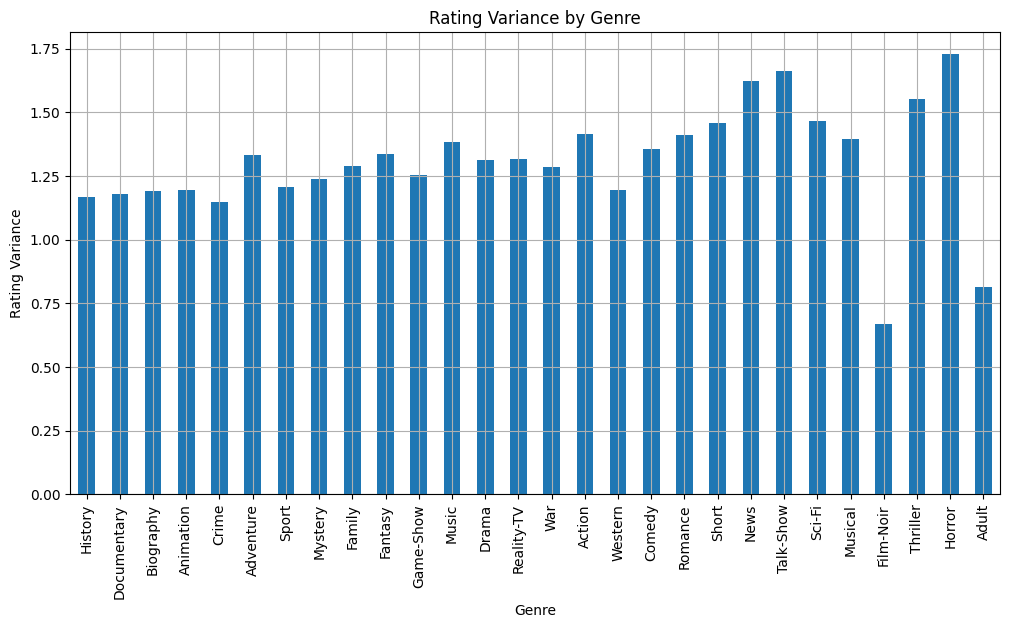

Top Genres by Consistency:


+-----------+------------------+------------------+----------+
|      genre|        avg_rating|     rating_stddev|num_titles|
+-----------+------------------+------------------+----------+
|    History| 7.355689749480354|1.1656812850892428|    166307|
|Documentary| 7.242723673710494|1.1808769300530413|   1066710|
|  Biography| 7.231379595471305|1.1896468403612979|    120239|
|  Animation| 7.141022829229424|1.1933474217498585|    558329|
|      Crime| 7.119747479164844|1.1473034427402384|    462156|
|  Adventure| 7.102805145533251| 1.331861805339486|    425298|
|      Sport| 7.097566853747102|1.2065580464938066|    273970|
|    Mystery| 7.091096574523475|1.2363291883159373|    225906|
|     Family| 7.086734646538702|1.2887297405716782|    824876|
|    Fantasy| 7.082029051146867|1.3374174014020186|    233267|
|  Game-Show| 7.081224705726748| 1.253636265321676|    424677|
|      Music|  7.07608566076293|1.3845363165103515|    420558|
|      Drama| 7.058362597775327|1.3123065277255326|   3

+----------+----------+-------------+----------+
|  director|avg_rating|rating_stddev|num_titles|
+----------+----------+-------------+----------+
|nm12769766|      10.0|          0.0|         3|
| nm8683494|      10.0|         NULL|         2|
|nm14476991|      10.0|         NULL|         1|
|nm13009737|      10.0|         NULL|         1|
| nm3084236|      10.0|         NULL|         1|
|nm11984442|      10.0|         NULL|         1|
| nm1273696|      10.0|         NULL|         1|
| nm3232956|      10.0|         NULL|         1|
| nm1956169|      10.0|         NULL|         3|
|nm12085919|      10.0|         NULL|         3|
| nm2756987|      10.0|         NULL|        14|
|nm10707296|      10.0|         NULL|         1|
| nm9801135|      10.0|         NULL|        11|
|nm11933208|      10.0|         NULL|         5|
| nm0994557|      10.0|         NULL|         1|
|nm10876673|      10.0|         NULL|         1|
| nm6908011|      10.0|         NULL|         1|
|nm12337136|      10

+----------+----------+-------------+----------+
|    writer|avg_rating|rating_stddev|num_titles|
+----------+----------+-------------+----------+
|nm10531951|      10.0|          0.0|         2|
|nm12019299|      10.0|         NULL|         1|
| nm3402342|      10.0|         NULL|        11|
| nm2263714|      10.0|         NULL|         8|
|nm13041266|      10.0|         NULL|         1|
| nm3232956|      10.0|         NULL|         2|
| nm1956169|      10.0|         NULL|         3|
|nm11984442|      10.0|         NULL|         1|
| nm9801135|      10.0|         NULL|         8|
|nm12085919|      10.0|         NULL|         3|
| nm5441137|      10.0|         NULL|         7|
|nm10876673|      10.0|         NULL|         1|
|nm13165718|      10.0|         NULL|         1|
|nm11933208|      10.0|         NULL|         5|
| nm6274721|      10.0|         NULL|        11|
| nm6706644|      10.0|         NULL|         2|
| nm6908011|      10.0|         NULL|         1|
| nm9902552|      10

24/12/22 15:03:29 WARN StandaloneAppClient$ClientEndpoint: Connection to localhost:7077 failed; waiting for master to reconnect...
24/12/22 15:03:29 WARN StandaloneSchedulerBackend: Disconnected from Spark cluster! Waiting for reconnection...
24/12/22 15:03:29 WARN StandaloneAppClient$ClientEndpoint: Connection to localhost:7077 failed; waiting for master to reconnect...
24/12/22 15:03:39 ERROR TaskSchedulerImpl: Lost executor 0 on 192.168.80.128: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


In [ ]:
# 8. Analyze rating consistency (for genres and crew) when run with 1 workers
AdvancedUsage.analyze_rating_consistency_usage(
    titles_df, rating_df, crew_df, output_crew_insights=True
)
# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")


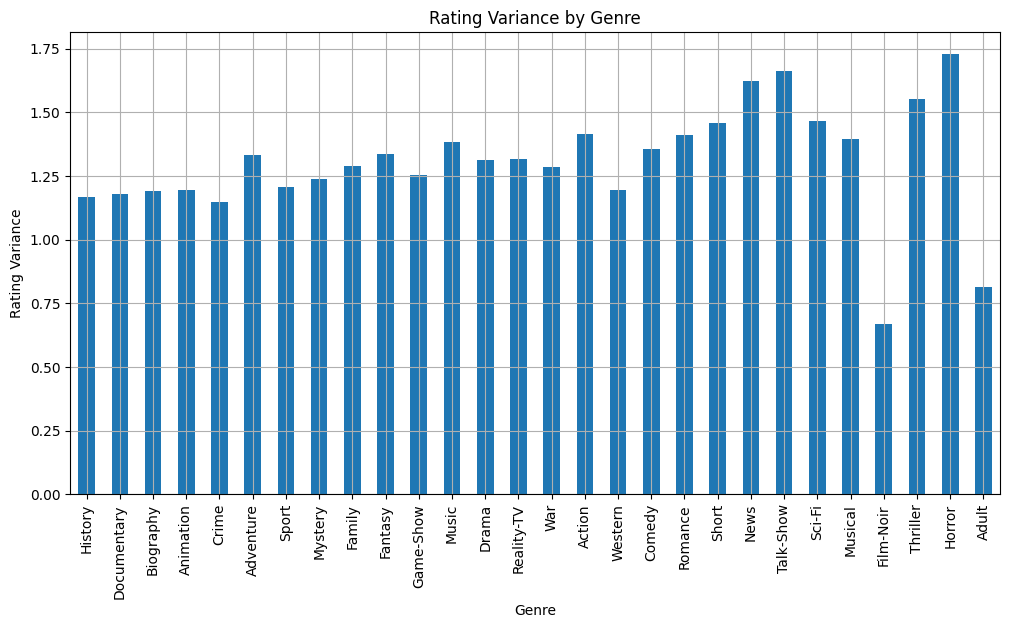

Top Genres by Consistency:


+-----------+-----------------+------------------+----------+
|      genre|       avg_rating|     rating_stddev|num_titles|
+-----------+-----------------+------------------+----------+
|    History|7.355689749480352|1.1656812850892428|    166307|
|Documentary|7.242723673710493|1.1808769300530413|   1066710|
|  Biography|7.231379595471305|1.1896468403612979|    120239|
|  Animation|7.141022829229424|1.1933474217498587|    558329|
|      Crime|7.119747479164844|1.1473034427402384|    462156|
|  Adventure|7.102805145533251|1.3318618053394862|    425298|
|      Sport|7.097566853747103|1.2065580464938066|    273970|
|    Mystery|7.091096574523475|1.2363291883159373|    225906|
|     Family|7.086734646538702|1.2887297405716782|    824876|
|    Fantasy|7.082029051146867|1.3374174014020186|    233267|
|  Game-Show|7.081224705726747| 1.253636265321676|    424677|
|      Music|7.076085660762928|1.3845363165103517|    420558|
|      Drama|7.058362597775327|1.3123065277255326|   3166290|
| Realit

+----------+----------+-------------+----------+
|  director|avg_rating|rating_stddev|num_titles|
+----------+----------+-------------+----------+
|nm12536512|      10.0|         NULL|         4|
|nm12769766|      10.0|          0.0|         3|
| nm7351580|      10.0|         NULL|         4|
|nm14476991|      10.0|         NULL|         1|
| nm6794553|      10.0|         NULL|         3|
| nm3084236|      10.0|         NULL|         1|
|nm10436472|      10.0|         NULL|         2|
| nm1273696|      10.0|         NULL|         1|
|nm14179880|      10.0|         NULL|         2|
| nm1956169|      10.0|         NULL|         3|
|nm12979026|      10.0|         NULL|         3|
| nm2756987|      10.0|         NULL|        14|
| nm9845861|      10.0|         NULL|         2|
| nm9801135|      10.0|         NULL|        11|
| nm5988453|      10.0|         NULL|         4|
| nm0994557|      10.0|         NULL|         1|
| nm7806517|      10.0|         NULL|         2|
| nm6908011|      10

+----------+----------+-------------+----------+
|    writer|avg_rating|rating_stddev|num_titles|
+----------+----------+-------------+----------+
|nm10531951|      10.0|          0.0|         2|
| nm5076037|      10.0|         NULL|         8|
| nm3402342|      10.0|         NULL|        11|
|nm11540048|      10.0|         NULL|         3|
|nm13041266|      10.0|         NULL|         1|
|nm12285422|      10.0|          0.0|         2|
| nm1956169|      10.0|         NULL|         3|
| nm4516138|      10.0|         NULL|         2|
| nm9801135|      10.0|         NULL|         8|
|nm11468234|      10.0|         NULL|         1|
| nm5441137|      10.0|         NULL|         7|
|nm10844716|      10.0|         NULL|         3|
|nm13165718|      10.0|         NULL|         1|
| nm7633559|      10.0|         NULL|         4|
| nm6274721|      10.0|         NULL|        11|
|nm11933208|      10.0|         NULL|         5|
| nm6908011|      10.0|         NULL|         1|
|nm11045547|      10

In [ ]:
# 8. Analyze rating consistency (for genres and crew) when run with 2 workers
AdvancedUsage.analyze_rating_consistency_usage(
    titles_df, rating_df, crew_df, output_crew_insights=True
)
# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")

In [38]:

# 9. Analyze runtime perception (how runtime correlates with ratings)
#AdvancedUsage.analyze_runtime_perception_usage(titles_df, rating_df)


24/12/22 14:58:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


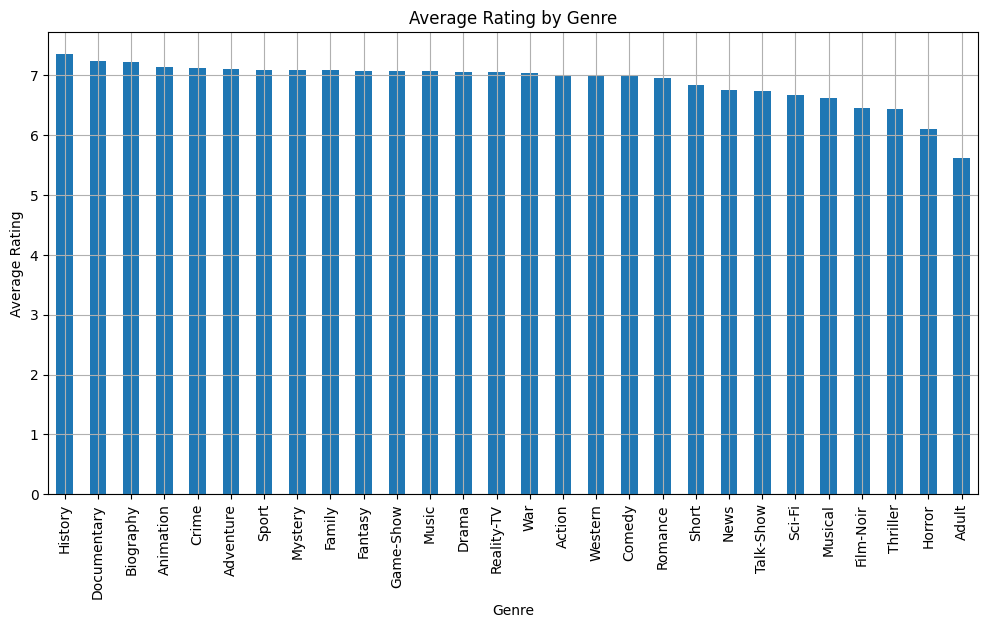

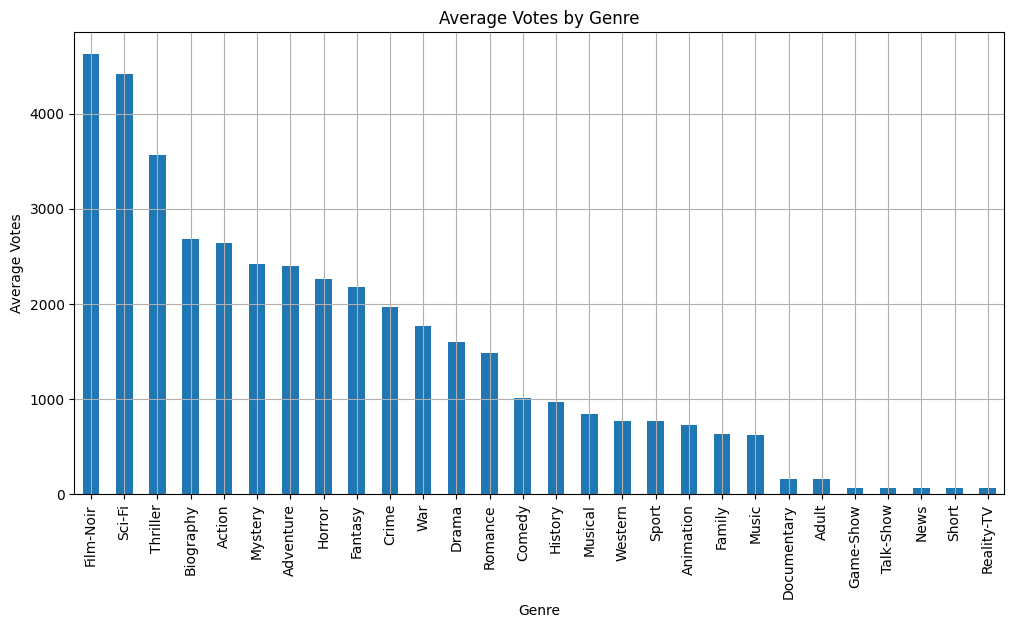

+-----------+------------------+------------------+------------------+----------+
|      genre|        avg_rating|     rating_stddev|         avg_votes|num_titles|
+-----------+------------------+------------------+------------------+----------+
|    History| 7.355689749480354|1.1656812850892428| 971.3576632753528|    166307|
|Documentary| 7.242723673710494|1.1808769300530413|158.06839497984268|   1066710|
|  Biography| 7.231379595471305|1.1896468403612979| 2685.642507314591|    120239|
|  Animation| 7.141022829229424|1.1933474217498585| 731.7357801925143|    558329|
|      Crime| 7.119747479164844|1.1473034427402384|1962.4096872540076|    462156|
|  Adventure| 7.102805145533251| 1.331861805339486|2397.8084830161833|    425298|
|      Sport| 7.097566853747102|1.2065580464938066| 766.1801254539452|    273970|
|    Mystery| 7.091096574523475|1.2363291883159373| 2417.929886755293|    225906|
|     Family| 7.086734646538702|1.2887297405716782| 627.8467205433441|    824876|
|    Fantasy| 7.

In [ ]:
# 10. Audience preferences by genre when run with 1 workers
AdvancedUsage.analyze_audience_preferences_by_genre_usage(titles_df, rating_df)
# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")


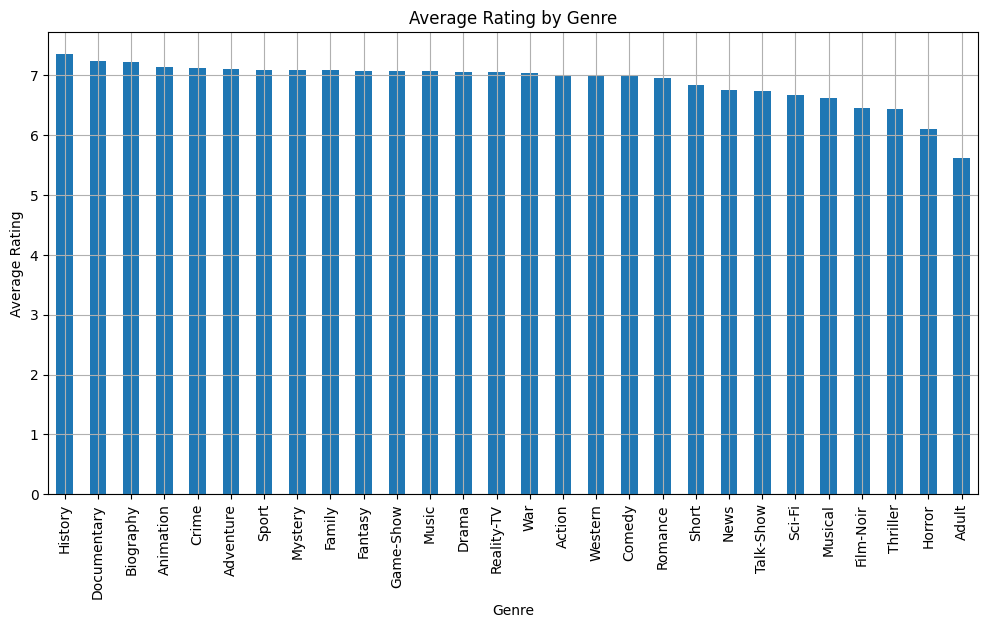

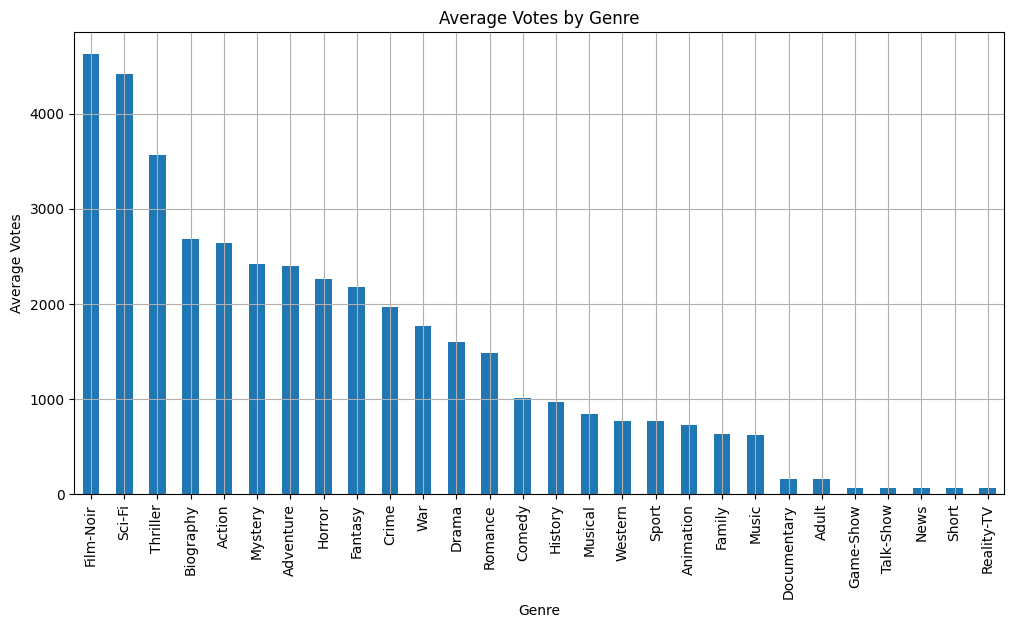

+-----------+-----------------+------------------+------------------+----------+
|      genre|       avg_rating|     rating_stddev|         avg_votes|num_titles|
+-----------+-----------------+------------------+------------------+----------+
|    History|7.355689749480352|1.1656812850892428| 971.3576632753528|    166307|
|Documentary|7.242723673710493|1.1808769300530413|158.06839497984268|   1066710|
|  Biography|7.231379595471305|1.1896468403612979| 2685.642507314591|    120239|
|  Animation|7.141022829229424|1.1933474217498587| 731.7357801925143|    558329|
|      Crime|7.119747479164844|1.1473034427402384|1962.4096872540076|    462156|
|  Adventure|7.102805145533251|1.3318618053394862|2397.8084830161833|    425298|
|      Sport|7.097566853747103|1.2065580464938066| 766.1801254539452|    273970|
|    Mystery|7.091096574523475|1.2363291883159373| 2417.929886755293|    225906|
|     Family|7.086734646538702|1.2887297405716782| 627.8467205433441|    824876|
|    Fantasy|7.0820290511468

In [16]:
# 10. Audience preferences by genre when run with 2 workers
AdvancedUsage.analyze_audience_preferences_by_genre_usage(titles_df, rating_df)
# Sử dụng SparkContext để lấy thông tin về các executors
workers_info = spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()

# Đếm số lượng workers (executors)
num_workers = len(workers_info) - 1

# In ra số lượng workers và thông tin chi tiết
print(f"Số lượng workers đang hoạt động: {num_workers}")
for worker in workers_info:
    print(f"Executor Info: {worker}")

In [ ]:
# 11. Identify consistent genres
AdvancedUsage.identify_consistent_genres_usage(titles_df, rating_df)


In [42]:
# 12. Compare ratings across regions (alternative titles)
# AdvancedUsage.compare_ratings_across_regions_usage(akas_df, rating_df)


In [ ]:

# 13. Analyze content type trends over time (movie vs TV series)
AdvancedUsage.analyze_content_type_trends_usage(titles_df)

In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, VectorAssembler, Normalizer
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import split, col, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from scipy.spatial.distance import cosine

# Initialize Spark Session
def init_spark():
    return SparkSession.builder \
        .appName("MovieRecommender") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

def load_and_preprocess_data(spark):
    
    # Filter and clean movies data
    titles_df = titles_df.filter(
        (col("titleType") == "movie") & 
        (col("isAdult") == "0")
    )
    
    # Split genres into array
    titles_df = titles_df.withColumn(
        "genres_array",
        split(col("genres"), ",")
    )
    
    # Join with ratings
    movie_data = titles_df.join(rating_df, "tconst", "inner")
    
    return movie_data

def create_genre_embeddings(movie_data):
    # Configure Word2Vec model
    word2vec = Word2Vec(
        vectorSize=100,
        minCount=0,
        inputCol="genres_array",
        outputCol="genre_embedding"
    )
    
    # Fit and transform
    model = word2vec.fit(movie_data)
    movie_data_with_embeddings = model.transform(movie_data)
    
    return movie_data_with_embeddings

def train_als_model(movie_data):
    # Convert ratings to float
    movie_data = movie_data.withColumn(
        "averageRating", 
        col("averageRating").cast("float")
    )
    
    # Initialize ALS model
    als = ALS(
        userCol="userId",
        itemCol="tconst",
        ratingCol="averageRating",
        coldStartStrategy="drop",
        nonnegative=True,
        rank=10,
        maxIter=10
    )
    
    # Add placeholder userIds for training
    movie_data = movie_data.withColumn("userId", lit(1))
    
    # Train model
    model = als.fit(movie_data)
    
    return model

def compute_similarity_matrix(movie_data_with_embeddings):
    # Convert to pandas for easier similarity computation
    embeddings_pd = movie_data_with_embeddings.select(
        "tconst", 
        "primaryTitle", 
        "genre_embedding"
    ).toPandas()
    
    n_movies = len(embeddings_pd)
    similarity_matrix = np.zeros((n_movies, n_movies))
    
    # Compute cosine similarity between all pairs
    for i in range(n_movies):
        for j in range(i+1, n_movies):
            sim = 1 - cosine(
                embeddings_pd.iloc[i]["genre_embedding"],
                embeddings_pd.iloc[j]["genre_embedding"]
            )
            similarity_matrix[i,j] = sim
            similarity_matrix[j,i] = sim
    
    return similarity_matrix, embeddings_pd

def get_recommendations(movie_id, similarity_matrix, embeddings_pd, als_model, alpha=0.5):
    # Get content-based recommendations
    movie_idx = embeddings_pd[embeddings_pd["tconst"] == movie_id].index[0]
    content_scores = similarity_matrix[movie_idx]
    
    # Get collaborative filtering recommendations
    cf_predictions = als_model.recommendForItemSubset(
        spark.createDataFrame([(movie_id,)], ["tconst"]), 
        100
    )
    cf_scores = cf_predictions.toPandas()
    
    # Combine scores
    final_scores = {}
    for idx, score in enumerate(content_scores):
        movie = embeddings_pd.iloc[idx]["tconst"]
        cf_score = cf_scores[cf_scores["tconst"] == movie]["prediction"].values[0] \
            if movie in cf_scores["tconst"].values else 0
        
        final_scores[movie] = alpha * score + (1 - alpha) * cf_score
    
    # Sort and get top recommendations
    recommendations = sorted(
        final_scores.items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:10]
    
    # Get movie details
    recommended_movies = embeddings_pd[
        embeddings_pd["tconst"].isin([r[0] for r in recommendations])
    ][["tconst", "primaryTitle"]]
    
    return recommended_movies

class MovieRecommender:
    def __init__(self):
        self.spark = init_spark()
        self.movie_data = None
        self.als_model = None
        self.similarity_matrix = None
        self.embeddings_pd = None
    
    def fit(self):
        # Load and preprocess data
        self.movie_data = load_and_preprocess_data(self.spark)
        
        # Create genre embeddings
        movie_data_with_embeddings = create_genre_embeddings(self.movie_data)
        
        # Train ALS model
        self.als_model = train_als_model(self.movie_data)titles_df
            compute_similarity_matrix(movie_data_with_embeddings)
    
    def recommend(self, movie_id, alpha=0.5):
        return get_recommendations(
            movie_id,
            self.similarity_matrix,
            self.embeddings_pd,
            self.als_model,
            alpha
        )
recommender = MovieRecommender()
recommender.fit()

# Lấy đề xuất cho một bộ phim
recommendations = recommender.recommend("tt0111161")  # Ví dụ với ID của phim The Shawshank Redemption
print(recommendations)

UnboundLocalError: cannot access local variable 'titles_df' where it is not associated with a value

In [8]:
recommender = MovieRecommender()
recommender.fit()

# Lấy đề xuất cho một bộ phim
recommendations = recommender.recommend("tt0111161")  # Ví dụ với ID của phim The Shawshank Redemption
print(recommendations)

UnboundLocalError: cannot access local variable 'titles_df' where it is not associated with a value